In [2]:
from xgboost import XGBRegressor
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
df = pl.read_parquet("../data/combined-2022-included.parquet")
pd_df = df.to_pandas()
pd_df["arwu_ranked_num"] = pd_df["arwu_ranked_num"] / pd_df["population"] * 1_000_000
pd_df["imo_total_score"] = pd_df["imo_total_score"] / np.log(pd_df["population"])
pd_df["arwu_ranked_num"] = np.where(pd_df["year"] < 2017, pd_df["arwu_ranked_num"], pd_df["arwu_ranked_num"] / 2)
# pd_df["arwu_ranked_num"] = np.maximum(pd_df["arwu_ranked_num"], pd_df["arwu_sum_score"]) / pd_df["population"] * 1_000_000
pd_df["gdp_pc_growth"] = 100 * pd_df["gdp_pc_growth"]
# pd_df["gdp_pc"] = np.log(pd_df["gdp_pc"])
# pd_df["population"] = np.log(pd_df["population"])

In [4]:
pd_df.head()

,country,year,gdp_pc,gdp_pc_growth,primary_completion,lower_sec_completion,upper_sec_completion,population,arwu_ranked_num,arwu_sum_score,math,read,science,in_math99,imo_total_score,democracy_eiu
0,AFG,2003,199.643228,92.702913,NaN,NaN,NaN,22645130.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN
1,AFG,2004,221.830531,-249.725464,NaN,NaN,NaN,23553551.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2,AFG,2005,254.115274,732.187384,NaN,NaN,NaN,24411191.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN
3,AFG,2006,274.015394,108.498820,NaN,NaN,NaN,25442944.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,3.06
4,AFG,2007,376.318296,1180.338266,NaN,NaN,NaN,25903301.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN


In [5]:
model = XGBRegressor()

In [6]:
prim_not_null = pd_df[pd_df["primary_completion"].notnull() & pd_df["lower_sec_completion"].notnull() & pd_df["upper_sec_completion"].notnull()]

In [7]:
X, y = (prim_not_null[["gdp_pc", "imo_total_score", "arwu_ranked_num", "gdp_pc_growth", "year", "democracy_eiu", "math"]], prim_not_null[["primary_completion", "lower_sec_completion", "upper_sec_completion"]])

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 123) 

In [9]:
model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
model.score(test_X, test_y)

0.714851620550241

In [11]:
model.score(train_X, train_y)

0.9993433739951852

In [12]:
model.score(X, y)

0.91925840309947

In [13]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01]
}

In [14]:
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='r2',  # Evaluation metric
                           n_jobs=-1,  # Use all available cores
                           verbose=1)

In [15]:
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=1)

In [16]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

Best parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best score:  -0.6875987096227157


In [17]:
best = grid_search.best_estimator_

In [18]:
best.score(test_X, test_y)

0.704687940457997

In [19]:
linear_data = pd_df[pd_df["primary_completion"].notnull() & pd_df["lower_sec_completion"].notnull() & pd_df["upper_sec_completion"].notnull()][["gdp_pc", "imo_total_score", "arwu_ranked_num", "gdp_pc_growth", "year", "democracy_eiu", "primary_completion", "lower_sec_completion", "upper_sec_completion"]].dropna()
lin_X, lin_y = (linear_data[["gdp_pc", "imo_total_score", "arwu_ranked_num", "gdp_pc_growth", "year", "democracy_eiu"]], linear_data[["primary_completion", "lower_sec_completion", "upper_sec_completion"]])
lin_train_X, lin_test_X, lin_train_y, lin_test_y = train_test_split(lin_X, lin_y, test_size = 0.3, random_state = 123) 

In [20]:
linear_data.describe()

,gdp_pc,imo_total_score,arwu_ranked_num,gdp_pc_growth,year,democracy_eiu,primary_completion,lower_sec_completion,upper_sec_completion
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,17047.183033,3.229972,0.123227,198.485018,2014.174263,6.227466,78.604672,63.318191,48.631493
std,19852.915328,3.290513,0.235711,361.077496,4.073378,1.832640,22.426314,25.875110,24.997101
min,244.145422,0.000000,0.000000,-2296.694199,2006.000000,0.320000,10.852290,4.360650,2.015800
25%,3346.795400,0.000000,0.000000,44.554899,2011.000000,5.185000,65.802431,45.775001,29.706016
50%,8170.408770,2.346884,0.000000,211.562173,2014.000000,6.455000,85.575207,62.056314,45.135000
75%,23527.867006,6.047559,0.119433,403.418468,2018.000000,7.737500,98.134634,86.469126,70.538795
max,101221.813477,12.612956,1.211386,1432.179319,2022.000000,9.930000,100.000000,99.978333,97.399788


In [21]:
linear_model = LinearRegression()
linear_model.fit(lin_train_X, lin_train_y)

LinearRegression()

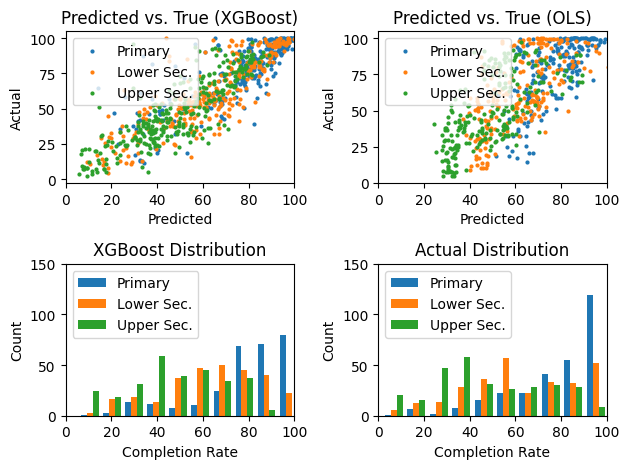

In [45]:
vars = ["primary_completion", "lower_sec_completion", "upper_sec_completion"]
names = ["Primary", "Lower Sec.", "Upper Sec."]
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
for i, v in enumerate(vars):
    ax0.scatter(np.hsplit(best.predict(test_X), 3)[i].ravel(), test_y[v], label=names[i], s=4)
    ax1.scatter(np.hsplit(linear_model.predict(lin_test_X), 3)[i].ravel(), lin_test_y[v], label=names[i], s=4)
a, b, c = np.hsplit(best.predict(test_X), 3)
ax2.hist([a.ravel(), b.ravel(), c.ravel()], label=names)
ax3.hist(test_y, label=names)

for ax in [ax0, ax1, ax2, ax3]:
    ax.legend(loc='upper left')
    ax.set_xlim((0, 100))
    # ax.set_aspect('equal')
for ax in (ax0, ax1):
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
for ax in (ax2, ax3):
    ax.set_xlabel("Completion Rate")
    ax.set_ylabel("Count")
    ax.set_ylim((0,150))
ax0.set_title("Predicted vs. True (XGBoost)")
ax1.set_title("Predicted vs. True (OLS)")
ax2.set_title("XGBoost Distribution")
ax3.set_title("Actual Distribution")
fig.tight_layout()
# fig.suptitle("Imputation results on test data", fontsize=16)
plt.savefig("xgboost.png", dpi=400)

In [99]:
X, y = (pd_df[["gdp_pc", "imo_total_score", "arwu_ranked_num", "gdp_pc_growth", "year", "democracy_eiu", "math"]], pd_df[["primary_completion", "lower_sec_completion", "upper_sec_completion"]])

In [101]:
a = best.predict(X)

In [105]:
pd_df["xg_primary_completion"], pd_df["xg_lower_sec_completion"], pd_df["xg_upper_sec_completion"] = np.hsplit(a, 3)

In [108]:
pd_df["primary_completion"] = np.where(pd_df["primary_completion"].notnull(), pd_df["primary_completion"], pd_df["xg_primary_completion"])
pd_df["lower_sec_completion"] = np.where(pd_df["lower_sec_completion"].notnull(), pd_df["lower_sec_completion"], pd_df["xg_lower_sec_completion"])
pd_df["upper_sec_completion"] = np.where(pd_df["upper_sec_completion"].notnull(), pd_df["upper_sec_completion"], pd_df["xg_upper_sec_completion"])

In [109]:
pd_df.describe()

,year,gdp_pc,gdp_pc_growth,primary_completion,lower_sec_completion,upper_sec_completion,population,arwu_ranked_num,arwu_sum_score,math,read,science,in_math99,imo_total_score,democracy_eiu,xg_primary_completion,xg_lower_sec_completion,xg_upper_sec_completion
count,5320.000000,5126.000000,5075.000000,5320.000000,5320.000000,5320.000000,5.300000e+03,5300.000000,5320.000000,441.000000,363.000000,365.000000,442.000000,5300.000000,2490.000000,5320.000000,5320.000000,5320.000000
mean,2012.500000,15325.512514,203.390942,73.315731,57.495898,41.532570,2.910476e+08,0.064058,13.822218,461.932227,464.379821,470.552348,0.933362,1.639827,5.453928,73.277679,57.461533,41.426338
std,5.766823,23704.041944,539.829646,22.502926,23.719886,21.486141,9.138962e+08,0.198723,130.259245,56.230835,49.879818,50.328600,1.457751,2.906371,2.222788,22.171118,23.163433,20.795898
min,2003.000000,114.367007,-5518.868118,4.152310,2.036170,0.495100,9.668000e+03,0.000000,0.000000,315.963154,290.918937,326.428759,0.000000,0.000000,0.320000,4.152310,5.252642,5.138081
25%,2007.750000,1707.629017,11.920733,61.192231,41.498101,25.141116,1.500115e+06,0.000000,0.000000,416.137170,425.146547,427.005823,0.056695,0.000000,3.450000,61.585521,41.673164,25.886451
50%,2012.500000,5536.609823,219.518969,79.670898,58.498301,40.086884,9.758046e+06,0.000000,0.000000,478.696484,480.551538,486.511394,0.486001,0.000000,5.745000,79.670898,58.756138,40.319273
75%,2017.250000,18805.641241,437.328514,91.433687,76.140261,54.728308,5.987791e+07,0.000000,0.000000,502.800431,500.671952,508.944869,1.184127,2.356299,7.210000,90.932583,75.525446,54.627335
max,2022.000000,240862.182448,9695.641990,102.338989,102.158730,97.399788,7.950947e+09,1.565903,2446.000000,574.663820,555.079856,563.748407,14.639147,14.306904,9.930000,102.346764,102.158730,97.831635


In [110]:
# pd_df.to_parquet("../data/combined-2022-xgboost-synthetic.parquet")